# 1. Cat Dog Classification

We will use convolution neural network to classify the cat dog image datasets. If you are using theano as backend, you may need change the code a little bit since theano and tensorflow have different image channel convention. 

In [1]:
import cv2
import os
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.applications.vgg16 import preprocess_input
from keras.optimizers import RMSprop, Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image


from sklearn.model_selection import train_test_split

%matplotlib inline

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))

Using TensorFlow backend.


## 1.1 Load the dataset

In [2]:
#This will load the images. Please put all training samples under one single folder and pass the 
#file directory.
def read_and_process_image(data_dir, width = 64, height = 64, channels = 3, preprocess = False):
    train_images = [data_dir + i for i in os.listdir(data_dir)]

    random.shuffle(train_images)
    
    def read_image(file_path, preprocess):
        img = image.load_img(file_path, target_size=(height, width))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        if preprocess:
            x = preprocess_input(x)
        return x

    def prep_data(images, preprocess):
        count = len(images)
        data = np.ndarray((count, width, height, channels), dtype=np.float32)

        for i, image_file in enumerate(images):
            image = read_image(image_file, preprocess)
            data[i] = image
    
        return data
    
    def read_labels(file_path):
        #Using 1 to represent dog and 0 for cat
        labels = []
        for i in file_path:
            label = 1 if 'dog' in i else 0
            labels.append(label)
        
        return labels

    X = prep_data(train_images, preprocess)
    labels = read_labels(train_images)
    
    assert X.shape[0] == len(labels)

    print("Train shape: {}".format(X.shape))
    
    return X, labels

In [3]:
#We will first try to build the CNN model by ourself. We will use a small width and height for starting 
#script. Later, you can modify these to see any change in model accuracy. Notice: large image may need 
#very long time to run. 
WIDTH = 64
HEIGHT = 64
CHANNELS = 3
X, y = read_and_process_image('input/train/', width = WIDTH, height = HEIGHT, channels = CHANNELS)

Train shape: (25000, 64, 64, 3)


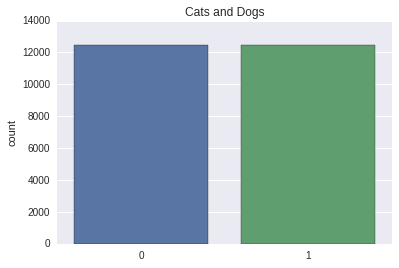

In [4]:
#Count plot the labels
sns.countplot(y)
sns.plt.title('Cats and Dogs')

In [15]:
def show_cats_and_dogs(X, idx):
    plt.figure(figsize=(10,5), frameon=True)
    img = X[idx, :, :, ::-1]
    img = img/255.
    plt.imshow(img)
    plt.show()

(64, 64, 3)


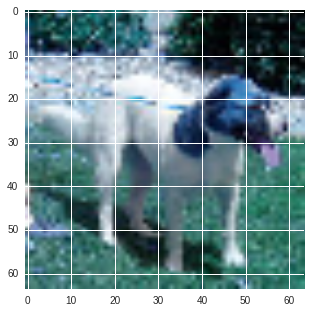

(64, 64, 3)


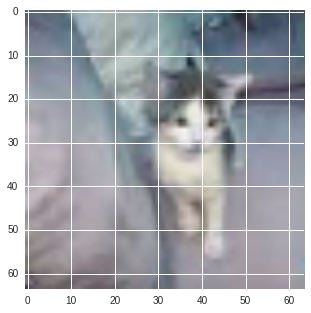

(64, 64, 3)


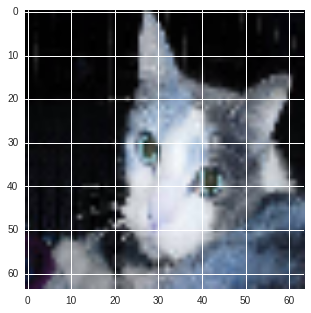

In [16]:
for idx in range(0, 3):
    show_cats_and_dogs(X, idx)

## 1.2 卷积神经网络

In [7]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3)

In [8]:
model = Sequential()
model.add(Conv2D(32, 3, input_shape=(WIDTH, HEIGHT, 3), activation='relu', padding="same"))
model.add(Conv2D(32, 3, activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, 3, activation='relu', padding="same"))
model.add(Conv2D(64, 3, activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, 3, activation='relu', padding="same"))
model.add(Conv2D(128, 3, activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, 3, activation='relu', padding="same"))
model.add(Conv2D(256, 3, activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
# Fit the model
history = model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs = 20, batch_size = 200)
# Final evaluation of the model
scores = model.evaluate(test_X, test_y, verbose=0)
print("Large CNN Error: %.2f%%" % (100 - scores[1] * 100))

Train on 17500 samples, validate on 7500 samples
Epoch 1/20
17500/17500 [==============================] - 9s - loss: 0.7592 - acc: 0.5166 - val_loss: 0.6884 - val_acc: 0.5907
Epoch 2/20
17500/17500 [==============================] - 7s - loss: 0.6811 - acc: 0.5619 - val_loss: 0.7638 - val_acc: 0.5019
Epoch 3/20
17500/17500 [==============================] - 7s - loss: 0.6661 - acc: 0.5929 - val_loss: 0.6409 - val_acc: 0.6428
Epoch 4/20
17500/17500 [==============================] - 7s - loss: 0.6340 - acc: 0.6431 - val_loss: 0.5758 - val_acc: 0.6877
Epoch 5/20
17500/17500 [==============================] - 7s - loss: 0.5851 - acc: 0.6931 - val_loss: 0.5275 - val_acc: 0.7289
Epoch 6/20
17500/17500 [==============================] - 7s - loss: 0.5358 - acc: 0.7309 - val_loss: 0.5647 - val_acc: 0.7135
Epoch 7/20
17500/17500 [==============================] - 7s - loss: 0.4702 - acc: 0.7815 - val_loss: 0.4339 - val_acc: 0.8035
Epoch 8/20
17500/17500 [==============================] - 7s -

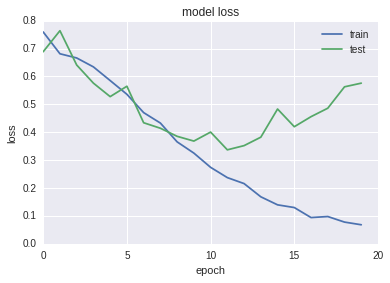

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

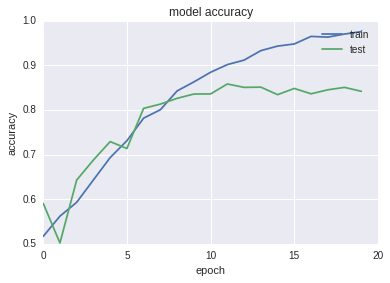

In [11]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## 1.3 VGG16 Pre-trained Model
In this section, we will use the VGG16 pre-trained model to apply on our dog-cat dataset. This is so-called transfer learning. The VGG16 is trained on ILSVRC-2012 dataset. Please see the paper: https://arxiv.org/abs/1409.1556 for more detail.

In [12]:
WIDTH = 224
HEIGHT = 224
CHANNELS = 3
X, y = read_and_process_image('input/train/', width = WIDTH, height = HEIGHT, channels = CHANNELS)

Train shape: (25000, 224, 224, 3)


In [13]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3)

In [14]:
train_X.shape

(17500, 224, 224, 3)

In [15]:
test_X.shape

(7500, 224, 224, 3)

In [16]:
#Use keras pre-trained VGG16 model for fine-tuning. We will freeze the convolution layers and replace
#the three fully connected layers by customerized fully connected layers. Also, the output will
#will be replaced by one single output, instead of 100 output for original datasets. 
def vgg16_model(input_shape = (WIDTH, HEIGHT, CHANNELS)):
    vgg16 = VGG16(include_top = False, weights = 'imagenet', input_shape = input_shape)

    for layer in vgg16.layers:
        layer.trainable = False

    last = vgg16.output
    
    #Please modify this part to fill your own fully connected layers.
    x = Flatten()(last)
    x = Dense(256, activation = 'relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation = 'relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation = 'sigmoid')(x)
    
    model = Model(inputs=vgg16.input, outputs=x)
    
    return model

In [17]:
model_vgg16 = vgg16_model()

In [18]:
#rmsprop = RMSprop(lr = 0.00001, rho = 0.9, epsilon = 1e-08, decay = 0.0)
#model_vgg16.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'])
model_vgg16.compile(loss='binary_crossentropy', optimizer = Adam(0.0001), metrics = ['accuracy'])

In [ ]:
model_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [ ]:
# Fit the model
history = model_vgg16.fit(train_X, train_y, validation_data=(test_X, test_y), epochs = 20, batch_size = 64)
# Final evaluation of the model
scores = model_vgg16.evaluate(test_X, test_y, verbose = 0)
print("VGG-16 Pretrained Model Error: %.2f%%" % (100 - scores[1] * 100))

Train on 17500 samples, validate on 7500 samples
Epoch 1/20
17500/17500 [==============================] - 127s - loss: 1.1522 - acc: 0.8967 - val_loss: 0.3495 - val_acc: 0.9657
Epoch 2/20
17500/17500 [==============================] - 126s - loss: 0.4955 - acc: 0.9525 - val_loss: 0.3089 - val_acc: 0.9675
Epoch 3/20
17500/17500 [==============================] - 126s - loss: 0.3996 - acc: 0.9591 - val_loss: 0.2544 - val_acc: 0.9688
Epoch 4/20
17500/17500 [==============================] - 126s - loss: 0.2510 - acc: 0.9691 - val_loss: 0.2167 - val_acc: 0.9728
Epoch 5/20
17500/17500 [==============================] - 126s - loss: 0.1801 - acc: 0.9730 - val_loss: 0.1797 - val_acc: 0.9721
Epoch 6/20
17500/17500 [==============================] - 126s - loss: 0.1290 - acc: 0.9774 - val_loss: 0.1649 - val_acc: 0.9723
Epoch 7/20
17500/17500 [==============================] - 127s - loss: 0.0959 - acc: 0.9812 - val_loss: 0.1557 - val_acc: 0.9719
Epoch 8/20
17500/17500 [========================

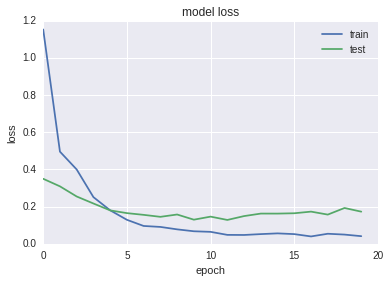

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

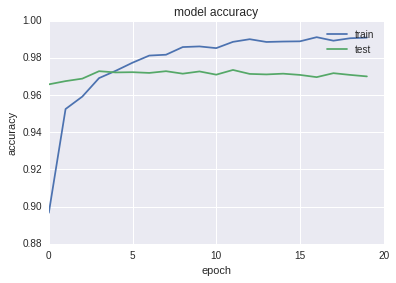

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## 1.4 Data Augmentation
keras provide a nice image generator for data augmentation. This is a way to prevent overfitting. Please see keras document for this function: https://keras.io/preprocessing/image/

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')


train_datagen.fit(train_X)

In [ ]:
history = model_vgg16.fit_generator(train_datagen.flow(train_X, train_y, batch_size = 64), 
                                    validation_data = (test_X, test_y), steps_per_epoch = train_X.shape[0] / 100, 
                                    epochs = 10)

Epoch 1/10
175/175 [==============================] - 90s - loss: 0.3719 - acc: 0.8717 - val_loss: 0.1581 - val_acc: 0.9580
Epoch 2/10
175/175 [==============================] - 90s - loss: 0.2804 - acc: 0.8813 - val_loss: 0.1178 - val_acc: 0.9673
Epoch 3/10
175/175 [==============================] - 90s - loss: 0.2909 - acc: 0.8835 - val_loss: 0.1206 - val_acc: 0.9672
Epoch 4/10
175/175 [==============================] - 90s - loss: 0.2611 - acc: 0.8933 - val_loss: 0.1064 - val_acc: 0.9685
Epoch 5/10
175/175 [==============================] - 92s - loss: 0.2541 - acc: 0.8956 - val_loss: 0.0991 - val_acc: 0.9687
Epoch 6/10
175/175 [==============================] - 94s - loss: 0.2530 - acc: 0.8972 - val_loss: 0.1180 - val_acc: 0.9668
Epoch 7/10
175/175 [==============================] - 94s - loss: 0.2529 - acc: 0.8944 - val_loss: 0.1040 - val_acc: 0.9684
Epoch 8/10
175/175 [==============================] - 90s - loss: 0.2257 - acc: 0.9069 - val_loss: 0.1186 - val_acc: 0.9693
Epoch 9/

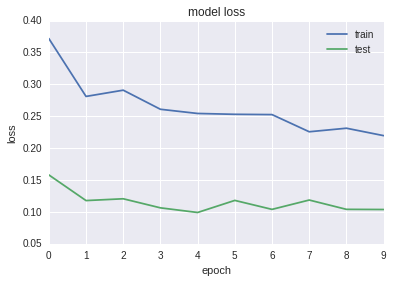

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

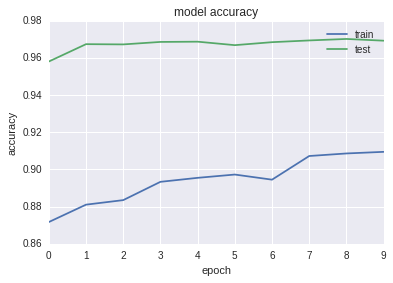

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()